## Testing Model
We will run the MCMC on a sample of the objects, with multiple chains to check the convergence.

In [1]:
import os; os.chdir('..')

In [2]:
import mcmc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

sns.set_style('white')
palette = sns.color_palette('dark', 5)
%matplotlib inline

n_samples = 4

Note that all the plots below will appear in the order they appear in this DataFrame, for me that is: Cortese, GOALS, H-ATLAS, HERUS, PCCS.

In [3]:
data = pd.read_csv(os.path.join('data', 'flux_measurements.csv'))
test_data = pd.concat([data_set.sample(n_samples) for source, data_set in data.groupby('Origin')])
test_data

,Name,RA,Dec,D,z,Origin,F60,F70,F100,F160,...,F350,F500,sigma60,sigma70,sigma100,sigma160,sigma250,sigma350,sigma500,L_IR
323,131,12:24:05.53,+07:02:28.6,7.097800e+23,0.005600,Cortese,NaN,NaN,552.000000,1263.000000,...,319.513328,114.147792,NaN,NaN,190.0000,136.0000,55.962925,41.203360,26.355780,NaN
418,274,12:53:29.17,+02:10:06.0,5.246200e+23,0.004139,Cortese,NaN,NaN,1197.000000,3001.000000,...,1049.468308,398.881098,NaN,NaN,235.0000,295.0000,96.815860,64.333428,30.445470,NaN
289,88,12:08:11.11,+02:52:41.8,5.246200e+23,0.004139,Cortese,NaN,NaN,12906.000000,14472.000000,...,3665.038872,1487.011284,NaN,NaN,2200.0000,2443.0000,454.045862,275.032428,132.778602,NaN
250,42,11:15:06.21,+14:47:13.5,5.258544e+23,0.004149,Cortese,NaN,NaN,12111.000000,18583.000000,...,4077.166116,1594.252044,NaN,NaN,2072.0000,1787.0000,490.794849,370.362020,131.415372,NaN
131,F13362+4831,38:17.5,+48:16:37.2,3.768006e+24,0.027820,GOALS,NaN,8113.0,9692.000000,7069.000000,...,1070.000000,336.000000,NaN,406.0,485.0000,354.0000,182.000000,73.000000,26.000000,11.56
159,F16504+0228,52:58.9,+02:24:03.3,3.410030e+24,0.024480,GOALS,NaN,26480.0,28030.000000,19000.000000,...,2834.000000,874.000000,NaN,1220.0,1280.0000,850.0000,437.000000,177.000000,56.000000,11.93
171,F18093-5744,13:39.6,-57:44:00.9,2.366962e+24,0.017350,GOALS,NaN,23870.0,28180.000000,20080.000000,...,2935.000000,928.000000,NaN,1190.0,1410.0000,1000.0000,526.000000,196.000000,65.000000,11.62
168,17578-0400,00:28.6,-04:01:16.3,2.067620e+24,0.014040,GOALS,NaN,34700.0,39780.000000,27580.000000,...,4300.000000,1306.000000,NaN,1620.0,1840.0000,1260.0000,650.000000,250.000000,78.000000,11.48
825,HATLAS J084441.6-005906,131.173559,-0.985274,2.068988e+25,0.163250,H-ATLAS,NaN,NaN,301.895466,280.458005,...,54.598000,14.007000,NaN,NaN,41.3164,47.9445,7.389000,8.093000,8.765000,NaN
1670,HATLAS J141849.9-000536,214.708089,-0.093379,6.644840e+24,0.052430,H-ATLAS,NaN,NaN,252.574622,304.373601,...,97.180000,40.716000,NaN,NaN,50.5903,50.5649,6.510000,7.392000,7.755000,NaN


## Run the MCMC
Do not be alarmed by the divergence warnings, we expect some objects to be poorly fitted by a MBB. Inspect the plots at the end to see the fits. When fitting the full set we will disregard any fits with a chisquare p-value < 0.95.

In [4]:
traces = {source: mcmc.get_trace(
    *mcmc.identify_flux_measurements(data_set),
    nu=mcmc.get_measurement_frequencies(data_set),
    n_sample=15000,
    d=data_set['D'],
    z=data_set['z'],
    chains=3,
    tune=2500
) for source, data_set in test_data.groupby('Origin')}

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mass, beta, temp]
Sampling 3 chains: 100%|██████████| 52500/52500 [03:00<00:00, 291.66draws/s]
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7020300075824293, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mass, beta, temp]
Sampling 3 chains: 100%|██████████| 52500/52500 [03:06<00:00, 281.75draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mass, beta, temp]
Sampling 3 chains: 100%|██████████| 52500/52500 [05:54<00:00, 147.99draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not mat

### Burn & Thinning
Set the thinning to reduce autocorrelation in the samples. Set burn if the samples have not converged after tuning, i.e. the plots on the right of the traceplot should look noisey but horizontal. If the distributions are not smooth, take more samples.

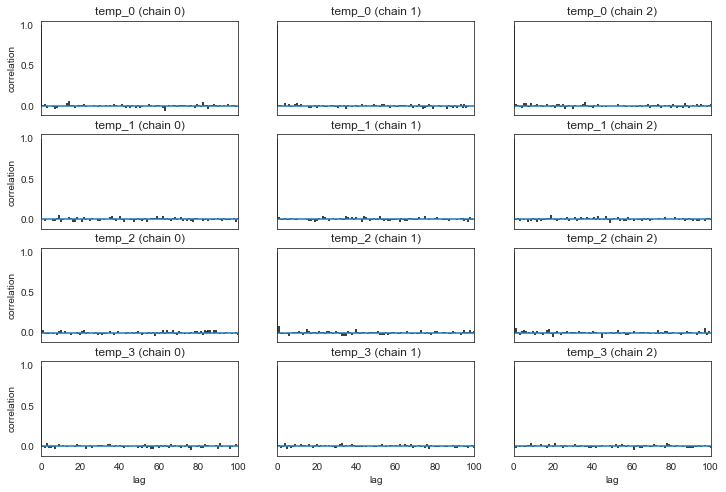

In [5]:
pm.autocorrplot(traces['Cortese'][::5], varnames=['temp']);

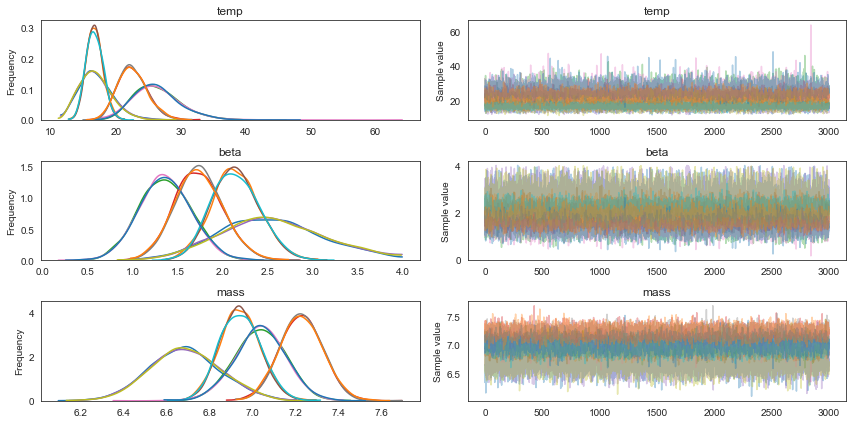

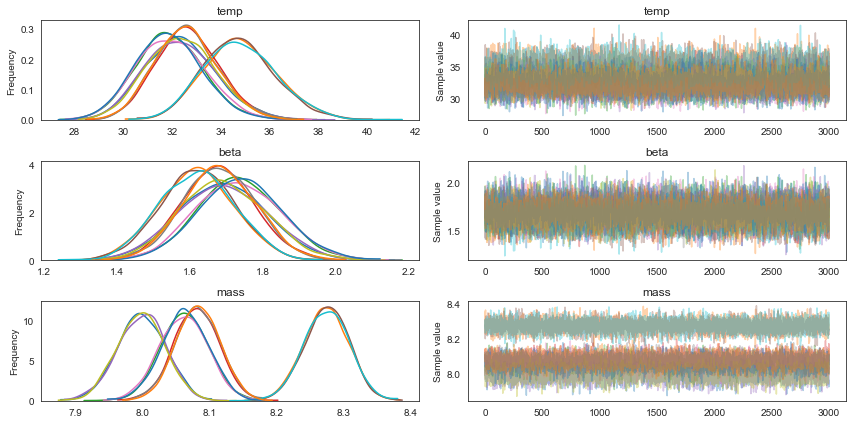

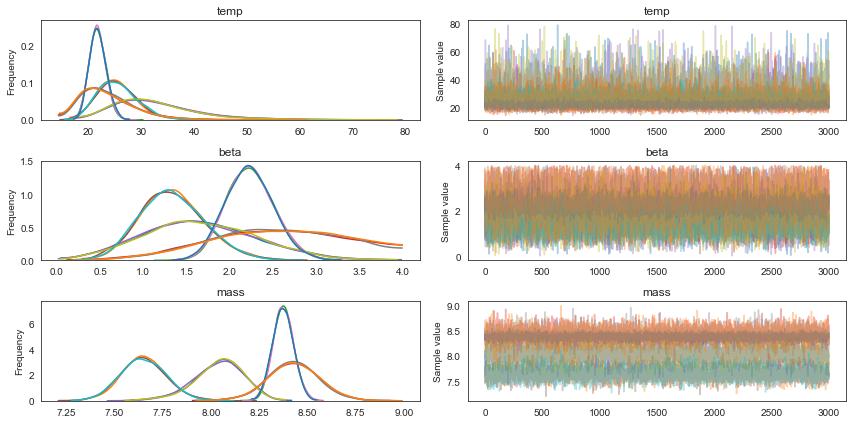

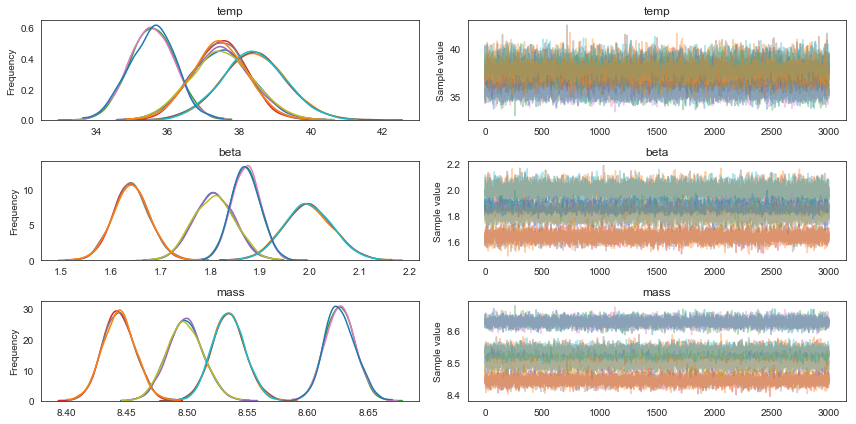

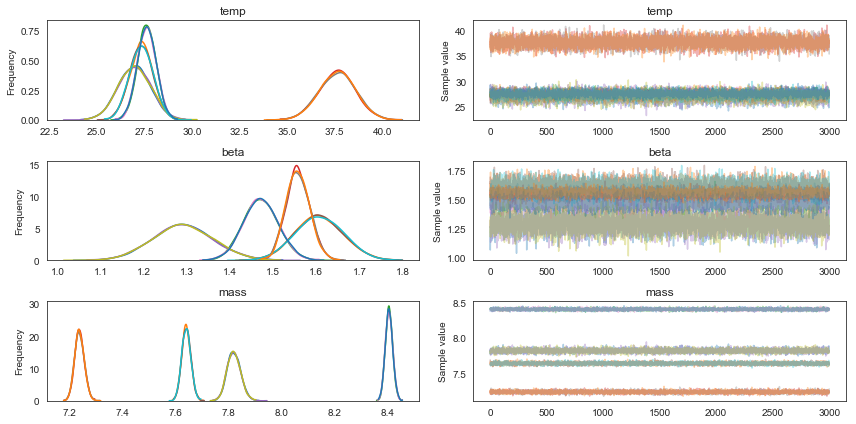

In [6]:
for source, trace in traces.items():
    x = pm.traceplot(trace[::5]);

In [7]:
def plot_SED(data, temp, beta, mass, ax=None, color='red'):
    if ax is None:
        plt.figure()
        ax = plt.gca()
    nu = mcmc.get_measurement_frequencies(data)
    wl = 1e6*mcmc.get_measurement_wavelengths(data)
    wl_cont = np.logspace(1.6, 3, 100)
    nu_cont = mcmc.constants.c/(1e-6*wl_cont)
    
    flux, err = mcmc.identify_flux_measurements(data)
    flux_predict = mcmc.flux_func(nu_cont, temp.mean(), beta.mean(), mass.mean(), data['D'], data['z'])
    trace_values = mcmc.flux_func(nu_cont, temp, beta, mass, data['D'], data['z'])[::5].T
    
    # plotting
    ax.plot(wl_cont, trace_values, color=color, alpha=0.005)
    ax.errorbar(wl, flux, yerr=err, fmt='.', capsize=5, color='black')
    ax.plot(wl_cont, flux_predict, linestyle='--', color='black', alpha=0.8, linewidth=1);
    
    # formatting
    ax.set_ylabel('Flux [mJy]')
    ax.set_xlabel(r'$\lambda$ [$\mu$m]')
    ax.set_title(data['Name'])
    ax.set_yscale('log'); ax.set_xscale('log')
    ax.set_xlim(min(wl_cont), max(wl_cont))

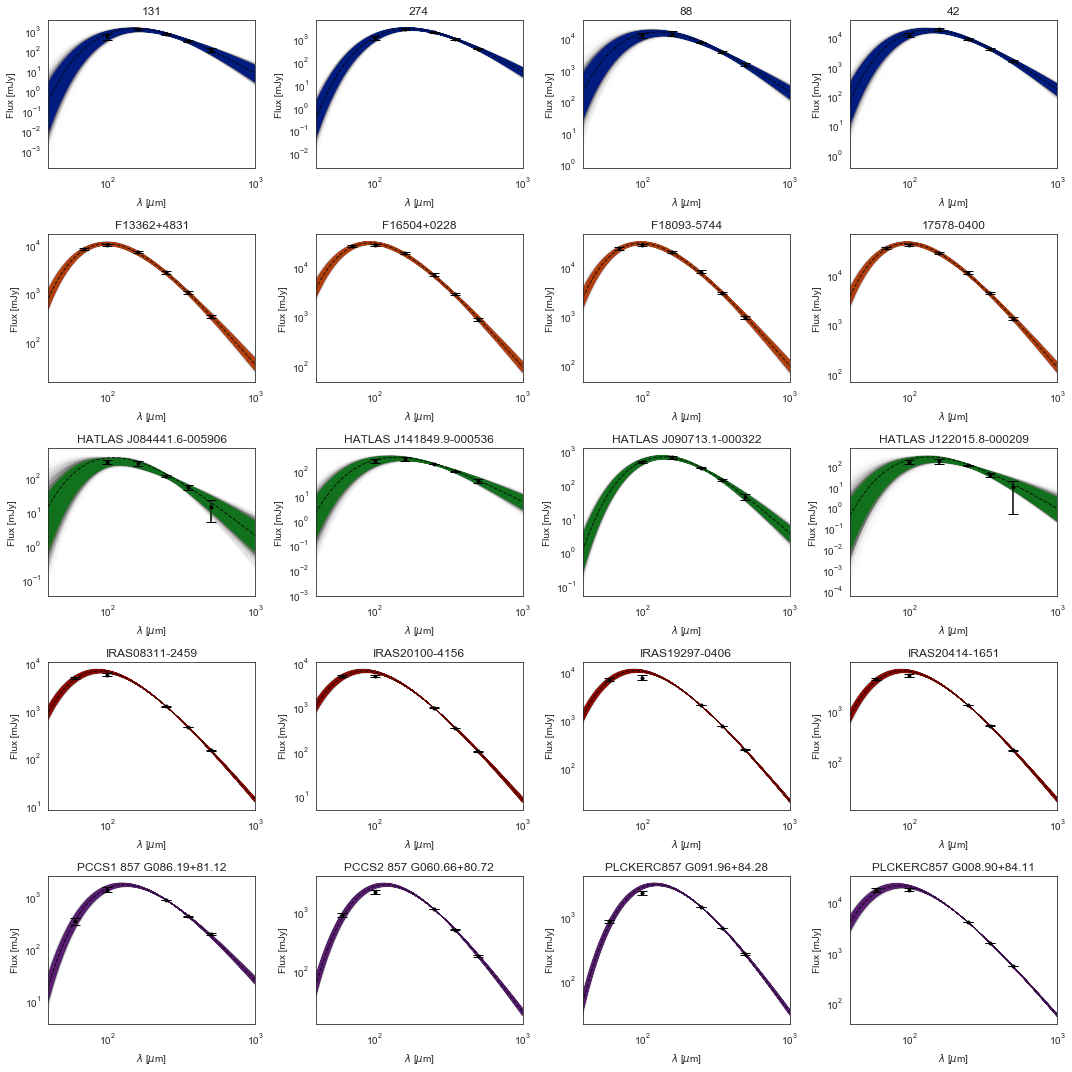

In [8]:
fig, axes = plt.subplots(nrows=test_data.shape[0]//n_samples, ncols=n_samples, figsize=(15, 15))
for row, (source, data_set) in enumerate(test_data.groupby('Origin')):
    for column, data in data_set.reset_index().iterrows():
        trace = traces[source]
        temp = trace.get_values('temp')[:, column]
        mass = trace.get_values('mass')[:, column]
        beta = trace.get_values('beta')[:, column]
        plot_SED(data, temp, beta, mass, ax=axes[row, column], color=palette[row])
plt.tight_layout()